<a href="https://colab.research.google.com/github/rahiakela/machine-learning-research-and-practice/blob/main/machine-learning-with-pytorch-and-scikit-learn/05_compressing_data_via_dimensionality_reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Compressing Data via Dimensionality Reduction

- [Unsupervised dimensionality reduction via principal component analysis](#Unsupervised-dimensionality-reduction-via-principal-component-analysis)
  - [The main steps behind principal component analysis](#The-main-steps-behind-principal-component-analysis)
  - [Extracting the principal components step-by-step](#Extracting-the-principal-components-step-by-step)
  - [Total and explained variance](#Total-and-explained-variance)
  - [Feature transformation](#Feature-transformation)
  - [Principal component analysis in scikit-learn](#Principal-component-analysis-in-scikit-learn)
  - [Assessing feature contributions](#Assessing-feature-contributions)
- [Supervised data compression via linear discriminant analysis](#Supervised-data-compression-via-linear-discriminant-analysis)
  - [Principal component analysis versus linear discriminant analysis](#Principal-component-analysis-versus-linear-discriminant-analysis)
  - [The inner workings of linear discriminant analysis](#The-inner-workings-of-linear-discriminant-analysis)
  - [Computing the scatter matrices](#Computing-the-scatter-matrices)
  - [Selecting linear discriminants for the new feature subspace](#Selecting-linear-discriminants-for-the-new-feature-subspace)
  - [Projecting examples onto the new feature space](#Projecting-examples-onto-the-new-feature-space)
  - [LDA via scikit-learn](#LDA-via-scikit-learn)
- [Nonlinear dimensionality reduction techniques](#Nonlinear-dimensionality-reduction-techniques)
  - [Visualizing data via t-distributed stochastic neighbor embedding](#Visualizing-data-via-t-distributed-stochastic-neighbor-embedding)
- [Summary](#Summary)

##Setup

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.datasets import load_digits
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patheffects as PathEffects

## Extracting the principal components

In [2]:
df_wine = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data", header=None)

In [3]:
df_wine.columns = [
    'Class label', 'Alcohol', 'Malic acid', 'Ash',
    'Alcalinity of ash', 'Magnesium', 'Total phenols',
    'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
    'Color intensity', 'Hue',
    'OD280/OD315 of diluted wines', 'Proline'
]
df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [4]:
# Splitting the data into 70% training and 30% test subsets.
X, y = df_wine.iloc[:, 1:], df_wine.iloc[:, 0]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

# standardize the features
sc = StandardScaler()
x_train_std = sc.fit_transform(x_train)
x_test_std = sc.fit(x_test)

In [5]:
# Let's compute the covariance matrix
cov_matrix = np.cov(x_train_std.T)
# performe the eigendecomposition
eigen_vals, eigen_vecs = np.linalg.eig(cov_matrix)
print(f"Eigenvalues \n{eigen_vals}")

Eigenvalues 
[4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


##Total and explained variance

In [6]:
# let's calculate the cumulative sum of explained variances
total = sum(eigen_vals)

var_exp = [(i / total) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

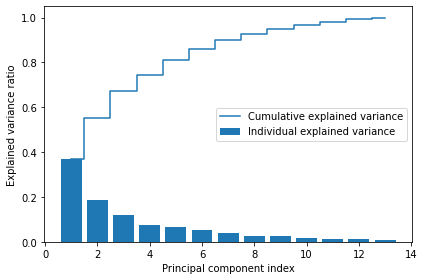

In [7]:
plt.bar(range(1, 14), var_exp, align="center", label="Individual explained variance")
plt.step(range(1, 14), cum_var_exp, where="mid", label="Cumulative explained variance")
plt.ylabel("Explained variance ratio")
plt.xlabel("Principal component index")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

##Feature transformation

In [8]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

In [9]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
print(f"Matrix W: \n {w}")

Matrix W: 
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


In [10]:
x_train_std[0].dot(w)

array([2.38299011, 0.45458499])

In [11]:
x_train_pca = x_train_std.dot(w)

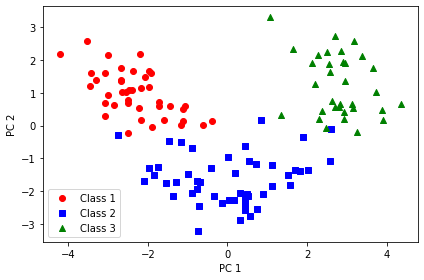

In [12]:
# let’s visualize the transformed Wine training dataset
colors = ['r', 'b', 'g']
markers = ['o', 's', '^']

for l, c, m in zip(np.unique(y_train), colors, markers):
  plt.scatter(x_train_pca[y_train==l, 0], x_train_pca[y_train == l, 1], c=c, label=f"Class {l}", marker=m)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

##Principal component analysis